# Cox Proportional Hazards and Random Survival Forests

Welcome to the final assignment in Course 2! In this assignment you'll develop risk models using survival data and a combination of linear and non-linear techniques. We'll be using a dataset with survival data of patients with Primary Biliary Cirrhosis (pbc). PBC is a progressive disease of the liver caused by a buildup of bile within the liver (cholestasis) that results in damage to the small bile ducts that drain bile from the liver. Our goal will be to understand the effects of different factors on the survival times of the patients. Along the way you'll learn about the following topics: 

- Cox Proportional Hazards
  - Data Preprocessing for Cox Models.
- Random Survival Forests
  - Permutation Methods for Interpretation.

## Outline

- [1. Import Packages](#1)
- [2. Load the Dataset](#2)
- [3. Explore the Dataset](#3)
- [4. Cox Proportional Hazards](#4)
    - [Exercise 1](#Ex-1)
- [5. Fitting and Interpreting a Cox Model](#5)
- [6. Hazard ratio](#3)
    - [Exercise 2](#Ex-2)
- [7. Harrell's C-Index](#7)
    - [Exercise 3](#Ex-3)
- [8. Random Survival Forests](#8)
- [9. Permutation Method for Interpretation](#9)

<a name='1'></a>
## 1. Import Packages

We'll first import all the packages that we need for this assignment. 

- `sklearn` is one of the most popular machine learning libraries.
- `numpy` is the fundamental package for scientific computing in python.
- `pandas` is what we'll use to manipulate our data.
- `matplotlib` is a plotting library.
- `lifelines` is an open-source survival analysis library.

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index as cindex
from sklearn.model_selection import train_test_split

from util import load_data

<a name='2'></a>
## 2. Load the Dataset

Run the next cell to load the data.

In [2]:
df = load_data()

<a name='3'></a>
## 3. Explore the Dataset

In the lecture videos `time` was in months, however in this assignment, `time` will be converted into years. Also notice that we have assigned a numeric value to `sex`, where `female = 0` and `male = 1`.

Next, familiarize yourself with the data and the shape of it. 

In [3]:
print(df.shape)

# df.head() only outputs the top few rows
df.head()

(258, 19)


,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,1.095890,1.0,0.0,58.765229,0.0,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,12.328767,0.0,0.0,56.446270,0.0,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,2.772603,1.0,0.0,70.072553,1.0,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,5.273973,1.0,0.0,54.740589,0.0,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
6,5.019178,0.0,1.0,55.534565,0.0,0.0,1.0,0.0,0.0,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0


Take a minute to examine particular cases.

In [4]:
i = 20
df.iloc[i, :]

time          11.175342
status         1.000000
trt            0.000000
age           44.520192
sex            1.000000
ascites        0.000000
hepato         1.000000
spiders        0.000000
edema          0.000000
bili           2.100000
chol         456.000000
albumin        4.000000
copper       124.000000
alk.phos    5719.000000
ast          221.880000
trig         230.000000
platelet      70.000000
protime        9.900000
stage          2.000000
Name: 23, dtype: float64

Now, split your dataset into train, validation and test set using 60/20/20 split. 

In [5]:
np.random.seed(0)
df_dev, df_test = train_test_split(df, test_size = 0.2)
df_train, df_val = train_test_split(df_dev, test_size = 0.25)

print("Total number of patients:", df.shape[0])
print("Total number of patients in training set:", df_train.shape[0])
print("Total number of patients in validation set:", df_val.shape[0])
print("Total number of patients in test set:", df_test.shape[0])

Total number of patients: 258
Total number of patients in training set: 154
Total number of patients in validation set: 52
Total number of patients in test set: 52


Before proceeding to modeling, let's normalize the continuous covariates to make sure they're on the same scale. Again, we should normalize the test data using statistics from the train data.

In [6]:
continuous_columns = ['age', 'bili', 'chol', 'albumin', 'copper', 'alk.phos', 'ast', 'trig', 'platelet', 'protime']
mean = df_train.loc[:, continuous_columns].mean()
std = df_train.loc[:, continuous_columns].std()
df_train.loc[:, continuous_columns] = (df_train.loc[:, continuous_columns] - mean) / std
df_val.loc[:, continuous_columns] = (df_val.loc[:, continuous_columns] - mean) / std
df_test.loc[:, continuous_columns] = (df_test.loc[:, continuous_columns] - mean) / std

Let's check the summary statistics on our training dataset to make sure it's standardized.

In [7]:
df_train.loc[:, continuous_columns].describe()

,age,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime
count,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02
mean,9.833404e-16,-3.258577e-16,1.153478e-16,1.153478e-16,5.767392e-18,1.326500e-16,-1.263059e-15,8.074349e-17,2.018587e-17,1.291896e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.304107e+00,-5.735172e-01,-1.115330e+00,-3.738104e+00,-9.856552e-01,-7.882167e-01,-1.489281e+00,-1.226674e+00,-2.058899e+00,-1.735556e+00
25%,-6.535035e-01,-4.895812e-01,-5.186963e-01,-5.697976e-01,-6.470611e-01,-5.186471e-01,-8.353982e-01,-6.884514e-01,-6.399831e-01,-7.382590e-01
50%,-6.443852e-03,-3.846612e-01,-2.576693e-01,5.663556e-02,-3.140636e-01,-3.416086e-01,-2.260984e-01,-2.495932e-01,-4.100373e-02,-1.398807e-01
75%,5.724289e-01,2.977275e-02,1.798617e-01,6.890921e-01,3.435366e-01,-4.620597e-03,6.061159e-01,3.755727e-01,6.617988e-01,3.587680e-01
max,2.654276e+00,5.239050e+00,6.243146e+00,2.140730e+00,5.495204e+00,4.869263e+00,3.058176e+00,5.165751e+00,3.190823e+00,4.447687e+00


<a name='4'></a>
## 4. Cox Proportional Hazards

Our goal is to build a risk score using the survival data that we have. We'll begin by fitting a Cox Proportional Hazards model to your data.

Recall that the Cox Proportional Hazards model describes the hazard for an individual $i$ at time $t$ as 

$$
\lambda(t, x) = \lambda_0(t)e^{\theta^T X_i}
$$

The $\lambda_0$ term is a baseline hazard and incorporates the risk over time, and the other term incorporates the risk due to the individual's covariates. After fitting the model, we can rank individuals using the person-dependent risk term $e^{\theta^T X_i}$. 

Categorical variables cannot be used in a regression model as they are. In order to use them, conversion to a series of variables is required.

Since our data has a mix of categorical (`stage`) and continuous (`wblc`) variables, before we proceed further we need to do some data engineering. To tackle the issue at hand we'll be using the `Dummy Coding` technique. In order to use Cox Proportional Hazards, we will have to turn the categorical data into one hot features so that we can fit our Cox model. Luckily, Pandas has a built-in function called `get_dummies` that will make it easier for us to implement our function. It turns categorical features into multiple binary features.

<img src="1-hot-encode.png" style="padding-top: 5px;width: 60%;left: 0px;margin-left: 150px;margin-right: 0px;">




<a name='Ex-1'></a>
### Exercise 1
In the cell below, implement the `to_one_hot(...)` function.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Remember to drop the first dummy for each each category to avoid convergence issues when fitting the proportional hazards model.</li>
    <li> Check out the <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html" > get_dummies() </a>  documentation. </li>
    <li>Use <code>dtype=np.float64</code>.</li>
</ul>
</p>

In [10]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def to_one_hot(dataframe, columns):
    '''
    Convert columns in dataframe to one-hot encoding.
    Args:
        dataframe (dataframe): pandas dataframe containing covariates
        columns (list of strings): list categorical column names to one hot encode
    Returns:
        one_hot_df (dataframe): dataframe with categorical columns encoded
                            as binary variables
    '''
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    one_hot_df = pd.get_dummies(dataframe, columns = columns,drop_first = 'True')
    
    ### END CODE HERE ###
    
    return one_hot_df

Now we'll use the function you coded to transform the training, validation, and test sets.

In [11]:
# List of categorical columns
to_encode = ['edema', 'stage']

one_hot_train = to_one_hot(df_train, to_encode)
one_hot_val = to_one_hot(df_val, to_encode)
one_hot_test = to_one_hot(df_test, to_encode)

print(one_hot_val.columns.tolist())
print(f"There are {len(one_hot_val.columns)} columns")

['time', 'status', 'trt', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'bili', 'chol', 'albumin', 'copper', 'alk.phos', 'ast', 'trig', 'platelet', 'protime', 'edema_0.5', 'edema_1.0', 'stage_2.0', 'stage_3.0', 'stage_4.0']
There are 22 columns


#### Expected output
```Python
['time', 'status', 'trt', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'bili', 'chol', 'albumin', 'copper', 'alk.phos', 'ast', 'trig', 'platelet', 'protime', 'edema_0.5', 'edema_1.0', 'stage_2.0', 'stage_3.0', 'stage_4.0']
There are 22 columns
```

### Look for new features
Now, let's take a peek at one of the transformed data sets. Do you notice any new features?

In [12]:
print(one_hot_train.shape)
one_hot_train.head()

(154, 22)


,time,status,trt,age,sex,ascites,hepato,spiders,bili,chol,...,alk.phos,ast,trig,platelet,protime,edema_0.5,edema_1.0,stage_2.0,stage_3.0,stage_4.0
279,3.868493,0.0,0.0,-0.414654,0.0,0.0,0.0,0.0,-0.300725,-0.096081,...,0.167937,0.401418,0.330031,0.219885,-1.137178,0,0,0,1,0
137,3.553425,1.0,0.0,0.069681,1.0,0.0,1.0,0.0,0.895363,0.406085,...,0.101665,0.472367,1.621764,-0.120868,-0.239610,0,0,0,1,0
249,4.846575,0.0,1.0,-0.924494,0.0,0.0,1.0,0.0,-0.510565,-0.225352,...,0.245463,1.899020,-0.580807,0.422207,0.159309,0,0,0,0,1
266,0.490411,1.0,0.0,1.938314,0.0,1.0,1.0,1.0,0.748475,-0.608191,...,-0.650254,-0.288898,-0.481443,-0.727833,1.356065,0,1,0,0,1
1,12.328767,0.0,0.0,0.563645,0.0,0.0,1.0,1.0,-0.405645,-0.210436,...,2.173526,-0.144699,-0.531125,-0.450972,-0.139881,0,0,0,1,0


<a name='5'></a>
## 5. Fitting and Interpreting a Cox Model

Run the following cell to fit your Cox Proportional Hazards model using the `lifelines` package.

In [13]:
cph = CoxPHFitter()
cph.fit(one_hot_train, duration_col = 'time', event_col = 'status', step_size=0.1)

<lifelines.CoxPHFitter: fitted with 154 total observations, 90 right-censored observations>

You can use `cph.print_summary()` to view the coefficients associated with each covariate as well as confidence intervals. 

In [14]:
cph.print_summary()

**Question:**

- According to the model, was treatment `trt` beneficial? 
- What was its associated hazard ratio? 
    - Note that the hazard ratio is how much an incremental increase in the feature variable changes the hazard.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Check your answer!</b></font>
</summary>
<p>
<ul>
<ul>
    <li>You should see that the treatment (trt) was beneficial because it has a negative impact on the hazard (the coefficient is negative, and exp(coef) is less than 1).</li>
    <li>The associated hazard ratio is ~0.8, because this is the exp(coef) of treatment.</li>
</ul>
</p>

We can compare the predicted survival curves for treatment variables. Run the next cell to plot survival curves using the `plot_covariate_groups()` function. 
- The y-axis is th survival rate
- The x-axis is time

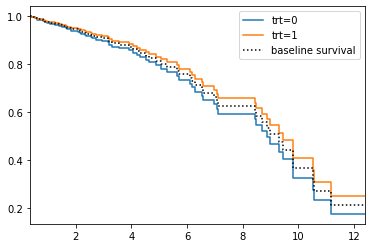

In [15]:
cph.plot_covariate_groups('trt', values=[0, 1]);

Notice how the group without treatment has a lower survival rate at all times (the x-axis is time) compared to the treatment group.

<a name='6'></a>
## 6. Hazard Ratio

Recall from the lecture videos that the Hazard Ratio between two patients was the likelihood of one patient (e.g smoker) being more at risk than the other (e.g non-smoker).
$$
\frac{\lambda_{smoker}(t)}{\lambda_{nonsmoker}(t)} = e^{\theta (X_{smoker} - X_{nonsmoker})^T}
$$

Where

$$
\lambda_{smoker}(t) = \lambda_0(t)e^{\theta X_{smoker}^T}
$$
and
$$
\lambda_{nonsmoker}(t) = \lambda_0(t)e^{\theta X_{nonsmoker}^T} \\
$$

<a name='Ex-2'></a>
### Exercise 2
In the cell below, write a function to compute the hazard ratio between two individuals given the cox model's coefficients.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>use numpy.dot</li>
    <li>use nump.exp</li>
</ul>
</p>


In [16]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def hazard_ratio(case_1, case_2, cox_params):
    '''
    Return the hazard ratio of case_1 : case_2 using
    the coefficients of the cox model.
    
    Args:
        case_1 (np.array): (1 x d) array of covariates
        case_2 (np.array): (1 x d) array of covariates
        model (np.array): (1 x d) array of cox model coefficients
    Returns:
        hazard_ratio (float): hazard ratio of case_1 : case_2
    '''
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    hr = np.exp((np.dot(cox_params,case_1.T))-(np.dot(cox_params,case_2.T)))
    
    ### END CODE HERE ###
    
    return hr

Now, evaluate it on the following pair of indivduals: `i = 1` and `j = 5`

In [17]:
i = 1
case_1 = one_hot_train.iloc[i, :].drop(['time', 'status'])

j = 5
case_2 = one_hot_train.iloc[j, :].drop(['time', 'status'])

print(hazard_ratio(case_1.values, case_2.values, cph.params_.values))

15.029017732492221


#### Expected Output:
```CPP
15.029017732492221
```

**Question:** 

Is `case_1` or `case_2` at greater risk? 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Check your answer!</b></font>
</summary>
<p>
<ul>
<ul>
    Important! The following answer only applies if you picked i = 1 and j = 5
    <li>You should see that `case_1` is at higher risk.</li>
    <li>The hazard ratio of case 1 / case 2 is greater than 1, so case 1 had a higher hazard relative to case 2</li>
</ul>
</p>

Inspect different pairs, and see if you can figure out which patient is more at risk.

In [18]:
i = 4
case_1 = one_hot_train.iloc[i, :].drop(['time', 'status'])

j = 7
case_2 = one_hot_train.iloc[j, :].drop(['time', 'status'])

print("Case 1\n\n", case_1, "\n")
print("Case 2\n\n", case_2, "\n")
print("Hazard Ratio:", hazard_ratio(case_1.values, case_2.values, cph.params_.values))

Case 1

 trt          0.000000
age          0.563645
sex          0.000000
ascites      0.000000
hepato       1.000000
spiders      1.000000
bili        -0.405645
chol        -0.210436
albumin      1.514297
copper      -0.481961
alk.phos     2.173526
ast         -0.144699
trig        -0.531125
platelet    -0.450972
protime     -0.139881
edema_0.5    0.000000
edema_1.0    0.000000
stage_2.0    0.000000
stage_3.0    1.000000
stage_4.0    0.000000
Name: 1, dtype: float64 

Case 2

 trt          0.000000
age          0.463447
sex          0.000000
ascites      0.000000
hepato       1.000000
spiders      0.000000
bili        -0.489581
chol        -0.309875
albumin     -1.232371
copper      -0.504348
alk.phos     2.870427
ast         -0.936261
trig        -0.150229
platelet     3.190823
protime     -0.139881
edema_0.5    0.000000
edema_1.0    0.000000
stage_2.0    0.000000
stage_3.0    0.000000
stage_4.0    1.000000
Name: 38, dtype: float64 

Hazard Ratio: 0.178045000699713


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Check your answer!</b></font>
</summary>
<p>
<ul>
<ul>
    Important! The following answer only applies if you picked i = 4 and j = 7
    <li>You should see that `case_2` is at higher risk.</li>
    <li>The hazard ratio of case 1 / case 2 is less than 1, so case 2 had a higher hazard relative to case 1</li>
</ul>
</p>

<a name='7'></a>
## 7. Harrell's C-index

To evaluate how good our model is performing, we will write our own version of the C-index. Similar to the week 1 case, C-index in the survival context is the probability that, given a randomly selected pair of individuals, the one who died sooner has a higher risk score. 

However, we need to take into account censoring. Imagine a pair of patients, $A$ and $B$. 

#### Scenario 1
- A was censored at time $t_A$ 
- B died at $t_B$
- $t_A < t_B$. 

Because of censoring, we can't say whether $A$ or $B$ should have a higher risk score. 

#### Scenario 2
Now imagine that $t_A > t_B$.

- A was censored at time $t_A$ 
- B died at $t_B$
- $t_A > t_B$

Now we can definitively say that $B$ should have a higher risk score than $A$, since we know for a fact that $A$ lived longer. 

Therefore, when we compute our C-index
- We should only consider pairs where at most one person is censored
- If they are censored, then their censored time should occur *after* the other person's time of death. 

The metric we get if we use this rule is called **Harrel's C-index**.

Note that in this case, being censored at time $t$ means that the true death time was some time AFTER time $t$ and not at $t$. 
- Therefore if $t_A = t_B$ and A was censored:
    - Then $A$ actually lived longer than $B$. 
    - This will effect how you deal with ties in the exercise below!



<a name='Ex-3'></a>
### Exercise 3
Fill in the function below to compute Harrel's C-index.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>If you get a division by zero error, consider checking how you count when a pair is permissible (in the case where one patient is censored and the other is not censored).</li>
</ul>
</p>

In [23]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def harrell_c(y_true, scores, event):
    '''
    Compute Harrel C-index given true event/censoring times,
    model output, and event indicators.
    
    Args:
        y_true (array): array of true event times
        scores (array): model risk scores
        event (array): indicator, 1 if event occurred at that index, 0 for censorship
    Returns:
        result (float): C-index metric
    '''
    
    n = len(y_true)
    assert (len(scores) == n and len(event) == n)
    
    concordant = 0.0
    permissible = 0.0
    ties = 0.0
    
    result = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' and 'pass' with your code) ###
    
    # use double for loop to go through cases
    for i in range(n):
        # set lower bound on j to avoid double counting
        for j in range(i+1, n):
            
            # check if at most one is censored
            if event[i]==1 or event[j]==1:
                pass
            
                # check if neither are censored
                if event[i]==1 and event[j]==1:
                    permissible += 1.0
                    
                    # check if scores are tied
                    if scores[i] == scores[j]:
                        ties += 1.0
                    
                    # check for concordant
                    elif y_true[i] < y_true[j] and scores[i] > scores[j]:
                        concordant += 1.0
                    elif y_true[i] > y_true[j] and scores[i] < scores[j]:
                        concordant += 1.0
                
                # check if one is censored
                elif event[i] != event[j]:
                    
                    # get censored index
                    censored = j
                    uncensored = i
                    
                    if event[i] == 0:
                        censored = i
                        uncensored = j
                        
                    # check if permissible
                    # Note: in this case, we are assuming that censored at a time
                    # means that you did NOT die at that time. That is, if you
                    # live until time 30 and have event = 0, then you lived THROUGH
                    # time 30.
                    if y_true[uncensored] <= y_true[censored]:
                        permissible += 1.0
                        
                        # check if scores are tied
                        if scores[uncensored] == scores[censored]:
                            # update ties 
                            ties += 1.0
                            
                        # check if scores are concordant 
                        if scores[uncensored] > scores[censored]:
                            concordant += 1.0
    
    # set result to c-index computed from number of concordant pairs,
    # number of ties, and number of permissible pairs (REPLACE 0 with your code)  
    result = (concordant + 0.5*ties) / permissible
    
    ### END CODE HERE ###
    
    return result   

You can test your function on the following test cases:

In [24]:
y_true = [30, 12, 84, 9]

# Case 1
event = [1, 1, 1, 1]
scores = [0.5, 0.9, 0.1, 1.0]
print("Case 1")
print("Expected: 1.0, Output: {}".format(harrell_c(y_true, scores, event)))

# Case 2
scores = [0.9, 0.5, 1.0, 0.1]
print("\nCase 2")
print("Expected: 0.0, Output: {}".format(harrell_c(y_true, scores, event)))

# Case 3
event = [1, 0, 1, 1]
scores = [0.5, 0.9, 0.1, 1.0]
print("\nCase 3")
print("Expected: 1.0, Output: {}".format(harrell_c(y_true, scores, event)))

# Case 4
y_true = [30, 30, 20, 20]
event = [1, 0, 1, 0]
scores = [10, 5, 15, 20]
print("\nCase 4")
print("Expected: 0.75, Output: {}".format(harrell_c(y_true, scores, event)))

# Case 5
y_true = list(reversed([30, 30, 30, 20, 20]))
event = [0, 1, 0, 1, 0]
scores = list(reversed([15, 10, 5, 15, 20]))
print("\nCase 5")
print("Expected: 0.583, Output: {}".format(harrell_c(y_true, scores, event)))

# Case 6
y_true = [10,10]
event = [0,1]
scores = [4,5]
print("\nCase 6")
print(f"Expected: 1.0 , Output:{harrell_c(y_true, scores, event):.4f}")

Case 1
Expected: 1.0, Output: 1.0

Case 2
Expected: 0.0, Output: 0.0

Case 3
Expected: 1.0, Output: 1.0

Case 4
Expected: 0.75, Output: 0.75

Case 5
Expected: 0.583, Output: 0.5833333333333334

Case 6
Expected: 1.0 , Output:1.0000


Now use the Harrell's C-index function to evaluate the cox model on our data sets.

In [25]:
# Train
scores = cph.predict_partial_hazard(one_hot_train)
cox_train_scores = harrell_c(one_hot_train['time'].values, scores.values, one_hot_train['status'].values)
# Validation
scores = cph.predict_partial_hazard(one_hot_val)
cox_val_scores = harrell_c(one_hot_val['time'].values, scores.values, one_hot_val['status'].values)
# Test
scores = cph.predict_partial_hazard(one_hot_test)
cox_test_scores = harrell_c(one_hot_test['time'].values, scores.values, one_hot_test['status'].values)

print("Train:", cox_train_scores)
print("Val:", cox_val_scores)
print("Test:", cox_test_scores)

Train: 0.8265139116202946
Val: 0.8544776119402985
Test: 0.8478543563068921


What do these values tell us ?

<a name='8'></a>
## 8. Random Survival Forests

This performed well, but you have a hunch you can squeeze out better performance by using a machine learning approach. You decide to use a Random Survival Forest. To do this, you can use the `RandomForestSRC` package in R. To call R function from Python, we'll use the `r2py` package. Run the following cell to import the necessary requirements. 


In [26]:
%load_ext rpy2.ipython
%R require(ggplot2)

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

forest = rpackages.importr('randomForestSRC', lib_loc='R')

from rpy2 import robjects as ro
R = ro.r

from rpy2.robjects import pandas2ri
pandas2ri.activate()

R[write to console]: Loading required package: ggplot2



Instead of encoding our categories as binary features, we can use the original dataframe since trees deal well with raw categorical data (can you think why this might be?).

Run the code cell below to build your forest.

In [27]:
model = forest.rfsrc(ro.Formula('Surv(time, status) ~ .'), data=df_train, ntree=300, nodedepth=5, seed=-1)

In [28]:
print(model)

                         Sample size: 154
                    Number of deaths: 64
                     Number of trees: 300
           Forest terminal node size: 15
       Average no. of terminal nodes: 6.54
No. of variables tried at each split: 5
              Total no. of variables: 17
       Resampling used to grow trees: swor
    Resample size used to grow trees: 97
                            Analysis: RSF
                              Family: surv
                      Splitting rule: logrank *random*
       Number of random split points: 10
                          Error rate: 19.07%




Finally, let's evaluate on our validation and test sets, and compare it with our Cox model.

In [29]:
result = R.predict(model, newdata=df_val)
scores = np.array(result.rx('predicted')[0])

print("Cox Model Validation Score:", cox_val_scores)
print("Survival Forest Validation Score:", harrell_c(df_val['time'].values, scores, df_val['status'].values))

Cox Model Validation Score: 0.8544776119402985
Survival Forest Validation Score: 0.8296019900497512


In [30]:
result = R.predict(model, newdata=df_test)
scores = np.array(result.rx('predicted')[0])

print("Cox Model Test Score:", cox_test_scores)
print("Survival Forest Validation Score:", harrell_c(df_test['time'].values, scores, df_test['status'].values))

Cox Model Test Score: 0.8478543563068921
Survival Forest Validation Score: 0.8621586475942783


Your random forest model should be outperforming the Cox model slightly. Let's dig deeper to see how they differ.

<a name='9'></a>
## 9. Permutation Method for Interpretation

We'll dig a bit deeper into interpretation methods for forests a bit later, but for now just know that random surival forests come with their own built in variable importance feature. The method is referred to as VIMP, and for the purpose of this section you should just know that higher absolute value of the VIMP means that the variable generally has a larger effect on the model outcome.

Run the next cell to compute and plot VIMP for the random survival forest.

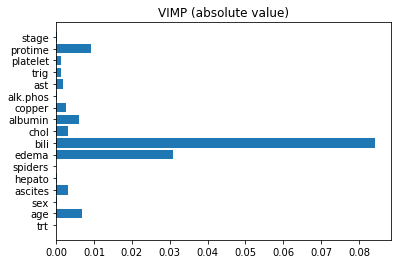

In [31]:
vimps = np.array(forest.vimp(model).rx('importance')[0])

y = np.arange(len(vimps))
plt.barh(y, np.abs(vimps))
plt.yticks(y, df_train.drop(['time', 'status'], axis=1).columns)
plt.title("VIMP (absolute value)")
plt.show()

### Question:

How does the variable importance compare to that of the Cox model? Which variable is important in both models? Which variable is important in the random survival forest but not in the Cox model? You should see that `edema` is important in both the random survival forest and the Cox model. You should also see that `bili` is important in the random survival forest but not the Cox model .

# Congratulations!

You've finished the last assignment in course 2! Take a minute to look back at the analysis you've done over the last four assignments. You've done a great job!